In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Precision WorkStation


No vtk
No vtkNot using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

In [3]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
win_id = 5

In [45]:
# stacks = ['MD661', 'MD662']
# stacks = ['MD661', 'ChatCryoJane201710']
# stacks = ['MD589', 'MD594']
stacks = ['MD589', 'MD661']
# stacks = ['MD589', 'ChatCryoJane201710']

In [46]:
sample_locations_allStacks = {stack: grid_parameters_to_sample_locations(win_id_to_gridspec(win_id=5, stack=stack)) 
                              for stack in stacks}

In [9]:
# addresses_df = DataFrame([(stack, sec, grid_idx) 
#            for stack in ['MD661', 'MD662'] 
#            for sec in np.arange(metadata_cache['section_limits'][stack][0], 
#                                 metadata_cache['section_limits'][stack][-1]+1)
#            for grid_idx in range(len(sample_locations_allStacks[stack]))], 
#           columns=['stack', 'section', 'grid_idx'])

In [10]:
# location_column = [sample_locations_allStacks[addr['stack']][addr['grid_idx']]
# for i, addr in addresses_df.iterrows()]

# addresses_df = addresses_df.assign(location=location_column)

In [47]:
grid_indices_lookup_allStacks = {}
for stack in stacks:
    try:
        grid_indices_lookup_allStacks[stack] = \
        DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                           by_human=True, timestamp='latest')
    except:
        sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD661" "/home/yuncong/CSHL_labelings_v3/MD661" --exclude "*" --include "*contours*"
latest timestamp:  12122017183504


In [48]:
from itertools import chain
all_labels = sorted(list(set(chain.from_iterable(set(grid_indices_lookup_allStacks[st].columns.tolist()) for st in stacks))))

In [49]:
address_multidx = pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
           for stack in sorted(stacks)
           for sec in np.arange(metadata_cache['section_limits'][stack][0], 
                                metadata_cache['section_limits'][stack][-1]+1)
           for grid_idx in range(len(sample_locations_allStacks[stack]))], 
          names=['stack', 'section', 'grid_idx'])

In [50]:
address_label_df_allStacks = DataFrame(columns=all_labels,
    index=address_multidx, data=False)

In [51]:
# surround_margins = [200, 500]
surround_margins = [200]

In [52]:
# Use the cached grid-indices files for speed up.

for stack in stacks:
# for stack in ['MD661']:
# for stack in ['ChatCryoJane201710']:

    grid_index_class_lookup = grid_indices_lookup_allStacks[stack]
    
    for sec in grid_index_class_lookup.index:
        sys.stderr.write('Computing class label to grid indices lookup-table for section %d...\n' % sec)
        if is_invalid(sec=sec, stack=stack):
            continue

        for label, grid_indices in grid_index_class_lookup.loc[sec].dropna().iteritems():
            if label == 'bg' or label == 'noclass' or 'negative' in label: # Ignore bg, noclass, x_negative
                continue
            
            name, side, margin, surr_name = parse_label(label)
            
            if name == '7N' and (margin is None or (margin is not None and int(margin) in surround_margins)):
            
                sys.stderr.write("%s, sec %d: %d patches from label %s.\n" % (stack, sec, len(grid_indices), label))
    #             t = time.time()
                for grid_idx in grid_indices:
                    address_label_df_allStacks.loc[(stack, sec, grid_idx), label] = True
    #             sys.stderr.write("%.2f s\n" % (time.time()-t))
    
del grid_indices_lookup_allStacks

Computing class label to grid indices lookup-table for section 92...
Computing class label to grid indices lookup-table for section 94...
Computing class label to grid indices lookup-table for section 95...
Computing class label to grid indices lookup-table for section 96...
Computing class label to grid indices lookup-table for section 97...
Computing class label to grid indices lookup-table for section 98...
Computing class label to grid indices lookup-table for section 99...
Computing class label to grid indices lookup-table for section 100...
Computing class label to grid indices lookup-table for section 101...
Computing class label to grid indices lookup-table for section 102...
Computing class label to grid indices lookup-table for section 103...
Computing class label to grid indices lookup-table for section 104...
Computing class label to grid indices lookup-table for section 105...
Computing class label to grid indices lookup-table for section 106...
Computing class label to gr

MD589, sec 176: 493 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 177...
MD589, sec 177: 137 patches from label 7N.
MD589, sec 177: 508 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 178...
MD589, sec 178: 149 patches from label 7N.
MD589, sec 178: 493 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 179...
MD589, sec 179: 166 patches from label 7N.
MD589, sec 179: 502 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 180...
MD589, sec 180: 187 patches from label 7N.
MD589, sec 180: 529 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 181...
MD589, sec 181: 191 patches from label 7N.
MD589, sec 181: 518 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table 

Computing class label to grid indices lookup-table for section 277...
MD589, sec 277: 60 patches from label 7N.
MD589, sec 277: 342 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 278...
MD589, sec 278: 79 patches from label 7N.
MD589, sec 278: 367 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 279...
MD589, sec 279: 97 patches from label 7N.
MD589, sec 279: 406 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 280...
MD589, sec 280: 121 patches from label 7N.
MD589, sec 280: 424 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 281...
MD589, sec 281: 148 patches from label 7N.
MD589, sec 281: 449 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 282...
MD589, sec 282: 170 patches from label 7N.
MD589

Computing class label to grid indices lookup-table for section 138...
MD661, sec 138: 143 patches from label 7N.
MD661, sec 138: 427 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 139...
MD661, sec 139: 160 patches from label 7N.
MD661, sec 139: 441 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 140...
MD661, sec 140: 187 patches from label 7N.
MD661, sec 140: 467 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 141...
MD661, sec 141: 209 patches from label 7N.
MD661, sec 141: 486 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 142...
MD661, sec 142: 242 patches from label 7N.
MD661, sec 142: 504 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 143...
MD661, sec 143: 268 patches from label 7N.
MD

MD661, sec 260: 522 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 261...
MD661, sec 261: 286 patches from label 7N.
MD661, sec 261: 534 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 262...
MD661, sec 262: 312 patches from label 7N.
MD661, sec 262: 552 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 263...
MD661, sec 263: 332 patches from label 7N.
MD661, sec 263: 566 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 264...
MD661, sec 264: 361 patches from label 7N.
MD661, sec 264: 574 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 265...
MD661, sec 265: 386 patches from label 7N.
MD661, sec 265: 586 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table 

In [ ]:
# This directly converts from boundary files and does not use the cached grid-indices files.

for stack in stacks:
# for stack in ['MD661']:
# for stack in ['ChatCryoJane201710']:

    prep_id = 2

    contours_df = DataManager.load_annotation_v4(stack=stack, by_human=True, suffix='contours', timestamp='latest')
    contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
    contours = contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])

    contours_df = convert_annotation_v3_original_to_aligned_cropped(contours, stack=stack)
    download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, prep_id=prep_id), is_dir=True)

    contours_grouped = contours_df.groupby('section')
    
    ##########################################
    
    for sec, cnt_group in contours_grouped:
        sys.stderr.write('Computing class label to grid indices lookup-table for section %d...\n' % sec)
        if is_invalid(sec=sec, stack=stack):
            continue
        polygons_this_sec = [(contour['name'], contour['vertices']) for contour_id, contour in cnt_group.iterrows()]
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, prep_id=prep_id)

        t = time.time()
        label_to_grid_indices_map = locate_patches_v2(grid_spec=win_id_to_gridspec(win_id=5, stack=stack), 
                                                      mask_tb=mask_tb, polygons=polygons_this_sec, \
                                                      surround_margins=surround_margins)
        sys.stderr.write("Identify in-polygon grid indices: %.2f s\n" % (time.time()-t))

        for label, grid_indices in label_to_grid_indices_map.iteritems():
            if label == 'bg' or label == 'noclass' or 'negative' in label: # Ignore bg, noclass, x_negative
                continue
            
            if parse_label(label)[0] != '7N':
                continue
            
            sys.stderr.write("%s, sec %d: %d patches from label %s.\n" % (stack, sec, len(grid_indices), label))
#             t = time.time()
            for grid_idx in grid_indices:
                address_label_df_allStacks.loc[(stack, sec, grid_idx), label] = True
#             sys.stderr.write("%.2f s\n" % (time.time()-t))

    del contours_df, contours_grouped, contours

In [ ]:
# # Different indexing method affects speed significantly.

# # Access a single element

# _ = address_label_df_allStacks['VCA'][(stack, sec, np.random.randint(0,1000,1)[0])]
# # The slowest run took 4.08 times longer than the fastest. This could mean that an intermediate result is being cached.
# # 10000 loops, best of 3: 37.3 µs per loop
# _ = address_label_df_allStacks.loc[(stack, sec, np.random.randint(0,1000,1)[0]), 'VCA']
# # 259 µs per loop
# address_label_df_allStacks.loc(axis=1)[(stack, sec, np.random.randint(0,1000,1)[0]), 'VCA']
# # 654 ms per loop

# # When access a list of elements, it is faster accessing them one by one.

# print address_label_df_allStacks.loc[(stack, sec, label_to_grid_indices_map['VCA'].tolist()), 'VCA']
# # 1 loop, best of 3: 17.5 s per loop

# for grid_idx in label_to_grid_indices_map['VCA']:
#     _ = address_label_df_allStacks.loc[(stack, sec, grid_idx), 'VCA']
# # 10 loops, best of 3: 48.8 ms per loop

In [ ]:
# address_label_df_allStacks = {}
    
# for stack in set(pd.unique(addresses_df['stack'])) & set(grid_indices_lookup_allStacks.keys()):
    
#     address_label_df_allStacks[stack] = {}
    
#     for sec, grid_lookups_this_section in grid_indices_lookup_allStacks[stack].iterrows():
#         print sec
#         if sec != 90:
#             break

#         t = time.time()
#         D = DataFrame(columns=grid_indices_lookup_allStacks[stack].columns, 
# #                       index=range(len(sample_locations_allStacks[stack])), 
#                     index=pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
#                                                      for grid_idx in range(len(sample_locations_allStacks[stack]))], 
#                                                     names=['stack', 'section', 'grid_idx']),
#                   data=False)
#         sys.stderr.write("construction: %.2f seconds.\n" % (time.time()-t))

#         # Form contingency matrix
#         t = time.time()
#         for label, grid_indices in grid_lookups_this_section.dropna().iteritems():
#             D[label][grid_indices] = True
#         sys.stderr.write("assign: %.2f seconds.\n" % (time.time()-t))

#         # Ignore bg(background) patches
#         D = D[~D['bg']]

#     address_label_df_allStacks[stack] = D

# # This takes long. Seems unnecessary. Sticking to the contigency matrix form is sufficient.
# #         t = time.time()
# #         patch_labels_df = D.apply(lambda row: D.columns[np.where(row)[0]].tolist(), axis=1)
# #         sys.stderr.write("convert to list: %.2f seconds.\n" % (time.time()-t))

# #         t = time.time()
# #         for grid_idx, labels in patch_labels_df.iteritems():
# #             address_to_labels_map[(stack, sec, grid_idx)] = labels
# #         sys.stderr.write("use address tuple as key: %.2f seconds.\n" % (time.time()-t))

# #             t = time.time()
# #             D.index = D.index.map(lambda grid_idx: (stack, sec, grid_idx))
# #             sys.stderr.write("use address tuple as key: %.2f seconds.\n" % (time.time()-t))

# #             address_label_df.append(D)

In [ ]:
# for stack in pd.unique(addresses_df['stack']):
#     for sec, grid_lookups_this_section in grid_indices_lookup_allStacks[stack].iteritems():
#         D = DataFrame(columns=grid_indices_lookup_allStacks[stack].columns, 
#                   index=range(len(sample_locations_allStacks[stack])), 
#                   data=False)
#         for label, grid_indices in grid_lookups_this_section.iteritems():
#             D[label][grid_indices] = True

#         patch_labels_df = D.apply(lambda row: D.columns[np.where(row)[0]].tolist(), axis=1)
#         [address_to_labels_map[patch_idx] for patch_idx, labels in patch_labels_df.iterrows()]

In [59]:
# patch_labels_df = DataFrame(columns=['labels'], index=addresses_df.index)
# patch_labels_df['labels'] = [[] for _ in range(len(patch_labels_df))]

# for stack in pd.unique(addresses_df['stack']):
#     if stack in grid_indices_lookup_allStacks:
#         grid_indices_lookup = grid_indices_lookup_allStacks[stack]
#         for sec in pd.unique(addresses_df[addresses_df['stack'] == stack]['section']):
#             print stack, sec
#             if sec in grid_indices_lookup.index:
#                 grid_lookups_this_section = grid_indices_lookup.loc[sec].dropna()
#                 patches_this_section = addresses_df[(addresses_df['stack'] == stack) & (addresses_df['section'] == sec)]

#                 for label, grid_indices in grid_lookups_this_section.iteritems():
#                     m = patches_this_section['grid_idx'].isin(grid_indices)
#                     for pi in m[m].index:
# #                         if pi not in patch_labels_df['labels']:
# #                             patch_labels_df.set_value(pi, 'labels', [])
#                         patch_labels_df['labels'][pi].append(label)

In [15]:
# whether_patches_have_desired_label = patch_labels_df['labels'].map(lambda labels: label in labels)

In [16]:
# address_tuples_with_desired_label = \
# addresses_with_desired_label.apply(lambda addr: (addr['stack'], addr['section'], addr['location']), axis=1).tolist()

In [40]:
# patches_with_desired_label = \
# extract_patches_given_locations_multiple_sections(address_tuples_with_desired_label, version='gray', win_id=win_id,
#                                                  location_or_grid_index='grid_index')

In [41]:
# display_images_in_grids(patches_with_desired_label[:100], nc=10, cmap=plt.cm.gray)

In [16]:
# images_16bit = {(st, sec): DataManager.load_image_v2(stack=st, prep_id=2, section=sec)[...,2]
#          for st, sec in set([(st, sec) for st, sec, gi in address_tuples_with_desired_label])}

In [23]:
# Using cv2.,imread is much faster than skimage.imread.

# t = time.time()
# img = DataManager.load_image_v2(stack='MD661', prep_id=2, section=200)
# # 142s
# img = cv2.imread(DataManager.get_image_filepath_v2(stack='MD661', prep_id=2, section=200), -1)
# # 17s
# print time.time() - t

In [56]:
# label = '7N'
# addresses_with_desired_label = address_label_df_allStacks[address_label_df_allStacks[label] == True].index
# address_tuples_with_desired_label = addresses_with_desired_label.tolist()

In [181]:
# features_df = DataFrame(index=address_multidx, columns=scheme_transform_multiindex)

In [53]:
# structure = 'Amb'
structure = '7N'
# structure = 'SNR'
positive_labels = [structure]
negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=200, 
                                      labels_found=address_label_df_allStacks.columns)
# negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=500, 
#                                       labels_found=address_label_df_allStacks.columns)

In [54]:
DataManager.enable_image_cache()

In [55]:
train_stack = 'MD589'
# train_stack = 'MD661'
# test_stack = 'ChatCryoJane201710'
test_stack = 'MD661'

q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
all_sections = np.unique(q.loc[train_stack].index.get_level_values('section'))
train_sections = [] # sections that contain patches of relevant classes.
for sec in all_sections:
    try:
        if len(q.loc[train_stack, sec].index.values.tolist()) > 0:
            train_sections.append(sec)
            print 'Section', sec, len(q.loc[train_stack, sec].index.values.tolist()), 'positive patches provided.'
    except:
        pass
    
# print train_sections
n_train_sections = 10
# n_train_sections = len(train_sections)
random_train_sections = np.random.choice(train_sections, min(len(train_sections), n_train_sections), replace=False)

positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[[train_stack], random_train_sections, :].index.values.tolist() 
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[[train_stack], random_train_sections, :].index.values.tolist() 

q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
all_sections = np.unique(q.loc[test_stack].index.get_level_values('section'))
test_sections = [] # sections that contain patches of relevant classes.
for sec in all_sections:
    try:
        if len(q.loc[test_stack, sec].index.values.tolist()) > 0:
            test_sections.append(sec)
            print 'Section', sec, 'provides', len(q.loc[test_stack, sec].index.values.tolist()), 'positive patches.'
    except:
        pass

n_test_sections = 10
random_test_sections = np.random.choice(test_sections, min(len(test_sections), n_test_sections), replace=False)

positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[[test_stack], random_test_sections, :].index.values.tolist()
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[[test_stack], random_test_sections, :].index.values.tolist()


print '# positive train =', len(positive_addresses_traindata)
print '# positive test =', len(positive_addresses_testdata)

Section 152 32 positive patches provided.
Section 153 49 positive patches provided.
Section 154 75 positive patches provided.
Section 155 108 positive patches provided.
Section 156 125 positive patches provided.
Section 157 146 positive patches provided.
Section 158 169 positive patches provided.
Section 159 190 positive patches provided.
Section 160 224 positive patches provided.
Section 161 230 positive patches provided.
Section 162 238 positive patches provided.
Section 163 251 positive patches provided.
Section 164 261 positive patches provided.
Section 165 280 positive patches provided.
Section 166 268 positive patches provided.
Section 167 265 positive patches provided.
Section 168 257 positive patches provided.
Section 169 252 positive patches provided.
Section 170 244 positive patches provided.
Section 171 235 positive patches provided.
Section 172 233 positive patches provided.
Section 173 231 positive patches provided.
Section 174 224 positive patches provided.
Section 175 22

In [16]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].index.values.tolist()

In [ ]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()

In [292]:
q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
all_sections = np.unique(q.loc['ChatCryoJane201710'].index.get_level_values('section'))
train_sections = [] # sections that contain patches of relevant classes.
for sec in all_sections:
    try:
        if len(q.loc['ChatCryoJane201710', sec].index.values.tolist()) > 0:
            train_sections.append(sec)
            print 'Section', sec, len(q.loc['ChatCryoJane201710', sec].index.values.tolist()), 'positive patches provided.'
    except:
        pass
    
# print train_sections
n_train_sections = 3
random_train_sections = np.random.choice(train_sections, min(len(train_sections), n_train_sections), replace=False)

positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710'], random_train_sections, :].index.values.tolist() 
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710'], random_train_sections, :].index.values.tolist() 

test_sections = [s for s in train_sections if s not in random_train_sections]
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710'], test_sections, :].index.values.tolist() 
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710'], test_sections, :].index.values.tolist() 

Section 79 574 positive patches provided.
Section 80 618 positive patches provided.
Section 81 672 positive patches provided.
Section 82 731 positive patches provided.
Section 83 800 positive patches provided.
Section 84 864 positive patches provided.
Section 85 944 positive patches provided.
Section 86 1035 positive patches provided.
Section 87 1100 positive patches provided.
Section 88 1175 positive patches provided.
Section 89 1246 positive patches provided.
Section 90 1348 positive patches provided.
Section 91 1315 positive patches provided.
Section 92 1294 positive patches provided.
Section 93 1273 positive patches provided.
Section 94 1264 positive patches provided.
Section 95 1257 positive patches provided.
Section 96 1278 positive patches provided.
Section 97 1280 positive patches provided.
Section 98 1311 positive patches provided.
Section 99 1313 positive patches provided.
Section 100 1353 positive patches provided.
Section 101 1362 positive patches provided.
Section 102 1391

In [152]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()

In [332]:
n_patches_required = 1000
half_size = 224.*XY_PIXEL_DISTANCE_LOSSLESS/2.

n_train_sections_all_structures = {}

for name_s in all_known_structures_sided:
    v = DataManager.load_original_volume(stack='atlasV5', structure=name_s, downscale=32)
    vol_um3 = np.count_nonzero(v > .5) * XY_PIXEL_DISTANCE_TB ** 3
    b = bbox_3d(v)
    n_train_sections = n_patches_required / (vol_um3 / ((b[5] - b[4]) * XY_PIXEL_DISTANCE_TB) / (half_size * half_size))
    # n_train_sections = vol_um3 / (n_patches_required * half_size * half_size * SECTION_THICKNESS)
    n_train_sections_all_structures[name_s] = n_train_sections

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7N_R.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_L.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_R.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_vo

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_R.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCP_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCP_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCP_L.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_vo

In [333]:
n_train_sections_all_structures

{'10N_L': 90.112505408913904,
 '10N_R': 90.112505408913904,
 '12N': 16.409912926992632,
 '3N_L': 39.456233421750667,
 '3N_R': 39.456233421750667,
 '4N_L': 437.50000000000011,
 '4N_R': 437.50000000000011,
 '5N_L': 18.689525033123218,
 '5N_R': 18.689525033123218,
 '6N_L': 223.23462414578586,
 '6N_R': 223.23462414578586,
 '7N_L': 14.337600089174579,
 '7N_R': 14.337600089174579,
 '7n_L': 69.556229327453153,
 '7n_R': 69.556229327453153,
 'AP': 59.666541775946051,
 'Amb_L': 133.94632206759445,
 'Amb_R': 133.94632206759445,
 'DC_L': 29.079606082685036,
 'DC_R': 29.079606082685036,
 'IC': 3.4192971670447241,
 'LC_L': 31.52085590465872,
 'LC_R': 31.52085590465872,
 'LRt_L': 25.188485263879372,
 'LRt_R': 25.188485263879372,
 'PBG_L': 142.85714285714286,
 'PBG_R': 142.85714285714286,
 'Pn_L': 12.298325183662865,
 'Pn_R': 12.298325183662865,
 'RMC_L': 45.764895330112722,
 'RMC_R': 45.764895330112722,
 'RtTg': 9.6258462282398458,
 'SC': 2.1708574887080396,
 'SNC_L': 113.66648992576883,
 'SNC_R': 11

In [59]:
DataManager.disable_image_cache()

In [56]:
# schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)']
# schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)', 'median_curve']
# schemes = ['normalize_mu_region_sigma_wholeImage_(-1,5)']
# schemes = ['stretch_min_max']
# schemes = [None, 'stretch_min_max']
# schemes = ['none']
# schemes = [None, 'median_curve']
# transforms = ['transform%d' % i for i in range(8)]
# scheme_transform_multiindex = pd.MultiIndex.from_product([schemes, transforms])

# features_dict = {(scheme, tfv): {} for scheme in schemes for tfv in transforms}
features_dict = defaultdict(dict)

In [57]:
# train_scheme = 'stretch_min_max'
train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
# train_scheme = 'none'
addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata

patches_with_desired_label = \
extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
#                                                     images={('MD661', 199): img},
                                              win_id=win_id, 
                                            normalization_scheme=train_scheme,
                                             location_or_grid_index='grid_index')

#     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

# for variant in [0]:
for variant in range(8):

    t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
    patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
    sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

    t = time.time()
    features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                 mean_img=mean_img, 
#                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                 batch_size=batch_size)
    sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

    for i, f in enumerate(features):
#             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
        features_dict[(train_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

No images are provided. Load instead.
Image MD589-IHC57-2015.07.31-01.18.16_MD589_2_0170_prep2_lossless.tif is cached.
Load image: 19.75 seconds.
No images are provided. Load instead.
Image MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_prep2_lossless.tif is cached.
Load image: 19.26 seconds.
No images are provided. Load instead.
Image MD589-N57-2015.07.30-19.59.14_MD589_2_0170_prep2_lossless.tif is cached.
Load image: 19.67 seconds.
No images are provided. Load instead.
Image MD589-IHC29-2015.07.30-23.16.01_MD589_1_0085_prep2_lossless.tif is cached.
Load image: 20.37 seconds.
No images are provided. Load instead.
Image MD589-N60-2015.07.30-20.11.20_MD589_3_0180_prep2_lossless.tif is cached.
Load image: 21.15 seconds.
No images are provided. Load instead.
Image MD589-N58-2015.07.30-20.03.53_MD589_2_0173_prep2_lossless.tif is cached.
Load image: 19.46 seconds.
No images are provided. Load instead.
Image MD589-N27-2015.07.30-17.49.06_MD589_1_0079_prep2_lossless.tif is cached.
Load image: 2

(6908, 1, 224, 224)


Feature computation: 10.44 seconds
Compute variants: 0.03 seconds


(6908, 1, 224, 224)


Feature computation: 10.22 seconds
Compute variants: 0.03 seconds


(6908, 1, 224, 224)


Feature computation: 10.53 seconds
Compute variants: 0.01 seconds


(6908, 1, 224, 224)


Feature computation: 10.35 seconds
Compute variants: 0.01 seconds


(6908, 1, 224, 224)


Feature computation: 10.56 seconds
Compute variants: 0.01 seconds


(6908, 1, 224, 224)


Feature computation: 10.57 seconds
Compute variants: 0.01 seconds


(6908, 1, 224, 224)


Feature computation: 11.12 seconds
Compute variants: 0.01 seconds


(6908, 1, 224, 224)


Feature computation: 11.16 seconds


In [60]:
# test_scheme = 'stretch_min_max'
test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'median_curve'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
# test_scheme = 'none'
addresses_to_compute = positive_addresses_testdata + negative_addresses_testdata

patches_with_desired_label = \
extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
#                                                     images={('MD661', 199): img},
                                              win_id=win_id, 
                                            normalization_scheme=test_scheme,
                                             location_or_grid_index='grid_index')

#     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

for variant in [0]:
# for variant in range(8):

    t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
    patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
    sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

    t = time.time()
    features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                 mean_img=mean_img, 
#                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                 batch_size=batch_size)
    sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

    for i, f in enumerate(features):
#             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
        features_dict[(test_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

No images are provided. Load instead.
Not using image_cache.
Load image: 78.52 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.73 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 20.00 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 41.15 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 64.05 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 45.36 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 19.13 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.83 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 19.17 seconds.
No images are provided. Load instead.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD661/MD661_prep2_lossless/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD661/MD661_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_lossless/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD661/MD661_prep2_lossless/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_prep2_lossless.tif"


Not using image_cache.
Load image: 33.32 seconds.
Compute variants: 0.03 seconds


(8537, 1, 224, 224)


Feature computation: 12.83 seconds


In [85]:
import random

No images are provided. Load instead.
Not using image_cache.
Load image: 20.20 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 21.05 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 18.95 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 18.07 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 17.99 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 17.79 seconds.


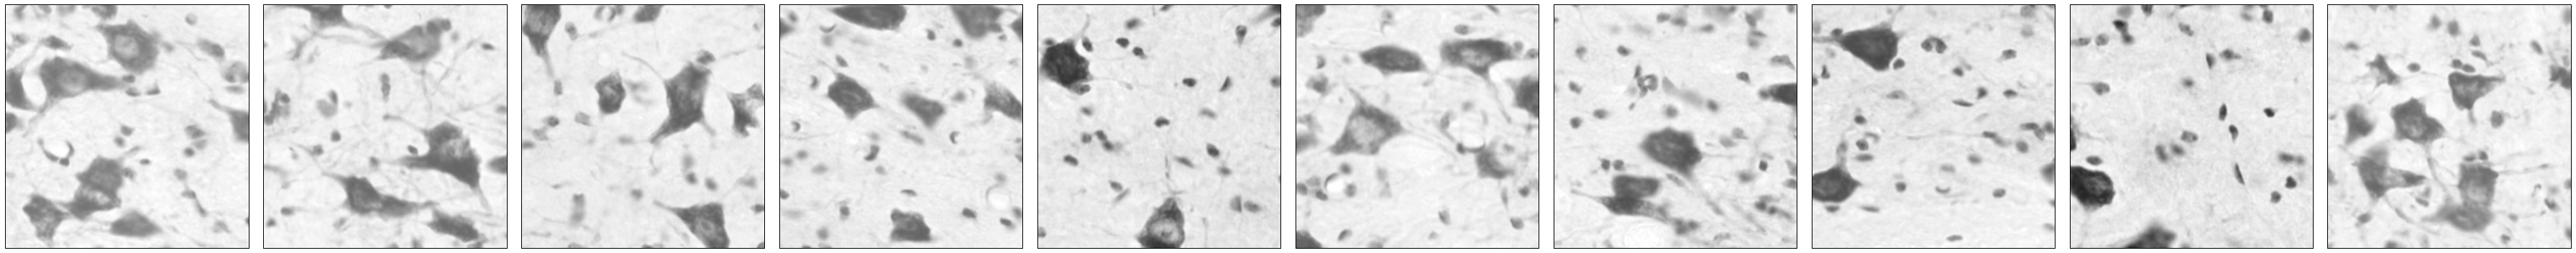

In [88]:
q = \
extract_patches_given_locations_multiple_sections(addresses=random.sample(positive_addresses_traindata, 10),
                                                  win_id=win_id, 
                                                normalization_scheme=train_scheme,
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

No images are provided. Load instead.
Not using image_cache.
Load image: 18.13 seconds.


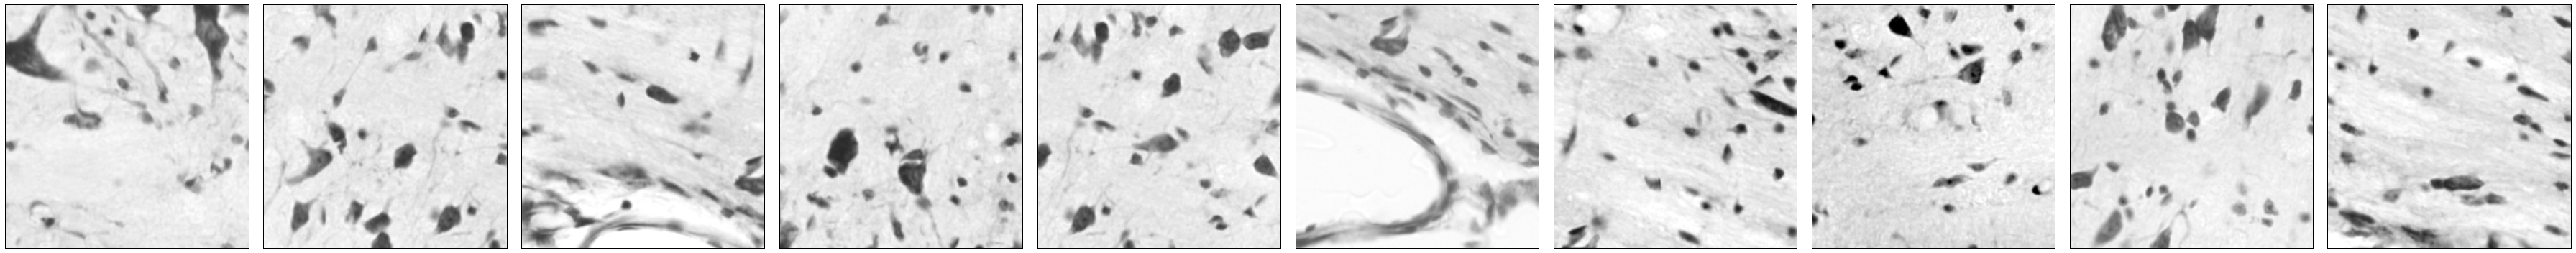

In [80]:
q = \
extract_patches_given_locations_multiple_sections(addresses=random.sample(negative_addresses_traindata, 10),
                                                  win_id=win_id, 
                                                normalization_scheme=train_scheme,
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

No images are provided. Load instead.
Not using image_cache.
Load image: 17.54 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.21 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.34 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.15 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.40 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 18.43 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 17.90 seconds.


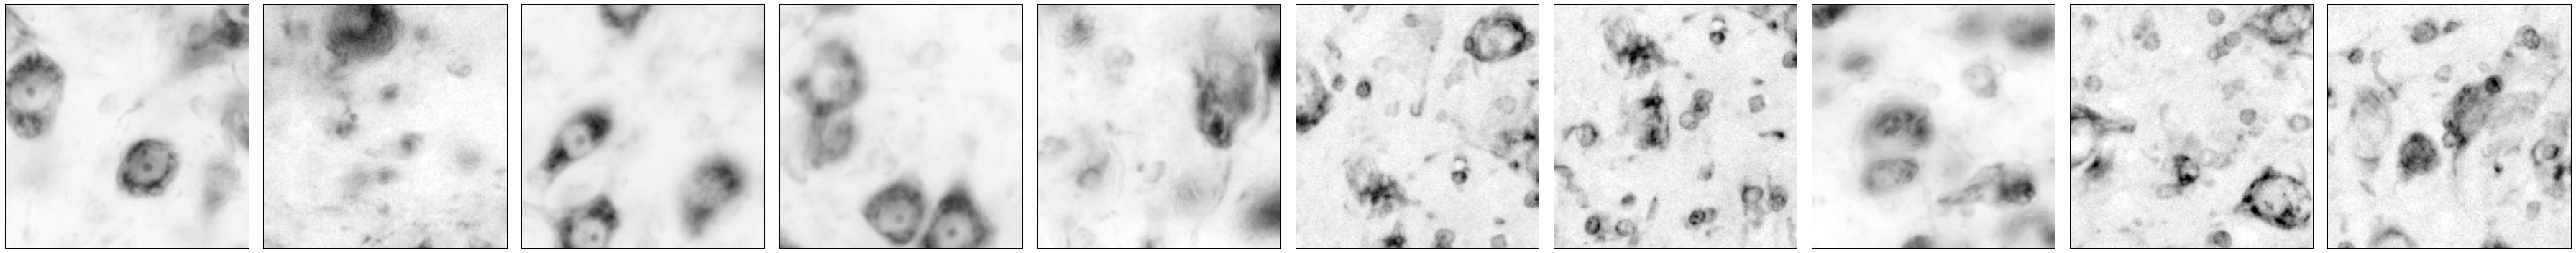

In [87]:
q = \
extract_patches_given_locations_multiple_sections(addresses=random.sample(positive_addresses_testdata, 10),
                                                  win_id=win_id, 
                                                normalization_scheme=test_scheme,
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

No images are provided. Load instead.
Not using image_cache.
Load image: 16.79 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.51 seconds.


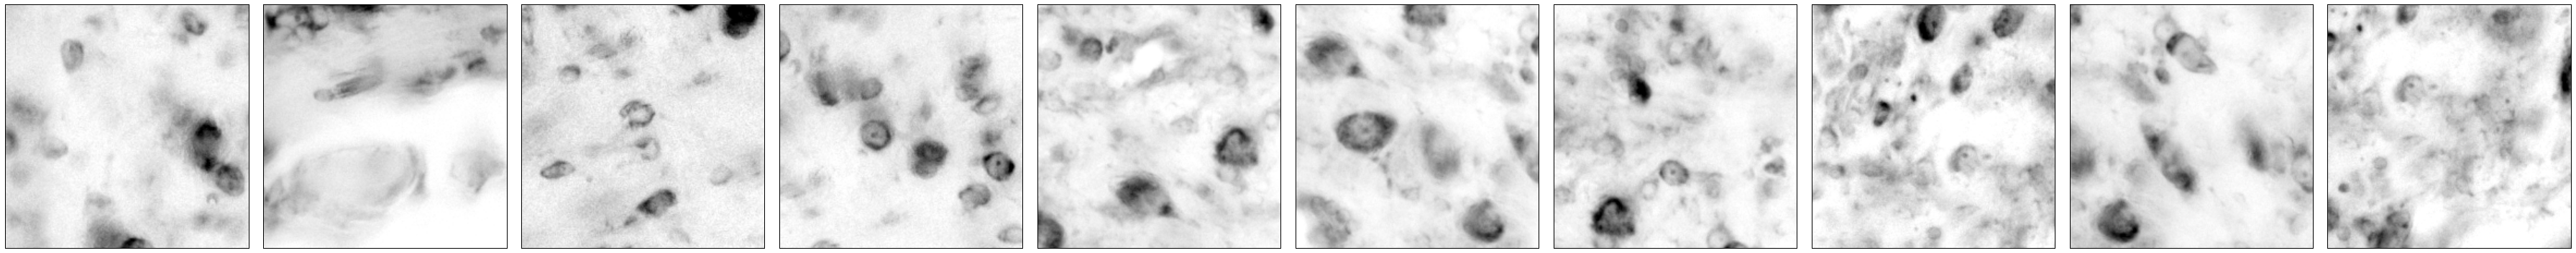

In [81]:
q = \
extract_patches_given_locations_multiple_sections(addresses=random.sample(negative_addresses_testdata, 10),
                                                  win_id=win_id, 
                                                normalization_scheme=test_scheme,
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

In [83]:
[(st, metadata_cache['sections_to_filenames'][st][sec], 
  sample_locations_allStacks[st][gid]) for st,sec, gid in negative_addresses_testdata[1000:1100:10]]

[('MD661',
  'MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151',
  array([11120, 10928])),
 ('MD661',
  'MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151',
  array([11120, 11568])),
 ('MD661',
  'MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151',
  array([11184, 11248])),
 ('MD661',
  'MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151',
  array([11248, 11120])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8560, 11312])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8624, 11440])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8688, 11248])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8752, 10800])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8752, 11440])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8816, 10864]))]

In [107]:
# q = \
# extract_patches_given_locations_multiple_sections(addresses=positive_addresses_traindata[:10],
#                                                   win_id=win_id, 
#                                                 normalization_scheme='normalize_mu_region_sigma_wholeImage',
#                                                  location_or_grid_index='grid_index')
# display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

# print np.min(np.reshape(q, (len(q),-1)), axis=1)
# print np.max(np.reshape(q, (len(q),-1)), axis=1)

In [66]:
def compute_classification_metrics(probs, labels):
    """
    Args:
        probs ((n,)-array of prediction value between 0 and 1): prediction.
        labels ((n,)-array of 0/1 or -1/1): ground-truth labels.
        
    Returns:
    """

    precision_allthresh = {}
    recall_allthresh = {}
    f1score_allthresh = {}
    tp_normalized_allthresh = {}
    fp_normalized_allthresh = {}
    acc_allthresh = {}
    
    n_pos = np.count_nonzero(labels == 1)
    n_neg = np.count_nonzero(labels != 1)
    n = len(labels)
    
    for th in np.arange(0., 1., 0.01):

        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in labels], soft=False,
                                     normalize=False, binary=True, decision_thresh=th)
        tp = cm[0,0]
        fn = cm[0,1]
        fp = cm[1,0]
        tn = cm[1,1]
        
        acc = (tp + tn) / float(n)

        tp_normalized = tp / n_pos
#                 fn_normalized = fn / n_pos
        fp_normalized = fp / n_neg
#                 tn_normalized = tn / n_neg

        precision = float(tp) / (tp + fp)
        recall = float(tp) / (tp + fn)
        f1score = 2*recall*precision/(recall+precision)

        tp_normalized_allthresh[float(th)] = tp_normalized
        fp_normalized_allthresh[float(th)] = fp_normalized
        precision_allthresh[float(th)] = precision
        recall_allthresh[float(th)] = recall
        f1score_allthresh[float(th)] = f1score
        acc_allthresh[float(th)] = acc
        
    optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f1score_allthresh[th] for th in np.arange(0, 1, 0.01)])]            
    fopt = f1score_allthresh[optimal_th]

    return {'acc': acc_allthresh,
        'tp': tp_normalized_allthresh,
#             fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized_allthresh
    'fp': fp_normalized_allthresh,
#             tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized_allthresh
    'precision': precision_allthresh,
    'recall': recall_allthresh,
    'f1score': f1score_allthresh,
           'opt_thresh': optimal_th,
           'fopt': fopt}

In [67]:
# n_train_list = [10, 50, 100,500,1000,2000,5000]
# n_train_list = [10, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000, 9000, 10000, 12000, 14000, 16000]
n_train_list = [10, 100, 200, 500, 1000, 2000, 5000, 10000, 15000]
test_f1s_all_ntrain = {}
test_accs_all_ntrain = {}
test_f1s05_all_ntrain = {}
test_accs05_all_ntrain = {}

"normalize_mu_region_sigma_wholeImage_(-1,5)" is the best scheme

In [68]:
train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# train_scheme = 'none'
test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'median_curve'
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
# train_scheme = 'stretch_min_max'
# test_scheme = 'stretch_min_max'
# train_scheme = 'none'
# test_scheme = 'none'

for n_train in n_train_list:

    training_accuracies = defaultdict(list)
    test_accuracies = defaultdict(list)
    training_f1s = defaultdict(list)
    test_f1s = defaultdict(list)
    test_accs05 = defaultdict(list)
    test_f1s05 = defaultdict(list)

    for trial in range(10):

        # If train and test data are from different sets
    #     n_train_pos = 5000
        n_train_pos = n_train
        if len(positive_addresses_traindata) < n_train_pos:
            continue
        training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)
        n_test_pos = 1000
        test_pos_indices = np.random.choice(range(len(positive_addresses_testdata)),
                                            size=min(len(positive_addresses_testdata), n_test_pos), 
                                            replace=False)

        # If train and test are from same set
    #     n_pos_total = len(positive_addresses)
    #     n_train_pos = 1000
    #     training_pos_indices = np.random.choice(range(n_pos_total), n_train_pos, replace=False)
    #     test_pos_indices = np.random.choice(np.setdiff1d(range(n_pos_total), training_pos_indices),
    #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
    #     n_test_pos = len(test_pos_indices)

        ###############

        # If train and test data are from different sets
    #     n_train_neg = 5000
        n_train_neg = n_train
        training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)
        n_test_neg = 1000
        test_neg_indices = np.random.choice(range(len(negative_addresses_testdata)),
                                            size=min(len(negative_addresses_testdata), n_test_neg), 
                                            replace=False)

        # If train and test are from same set
    #     n_neg_total = len(negative_addresses)
    #     n_train_neg = 1000
    #     training_neg_indices = np.random.choice(range(n_neg_total), n_train_neg, replace=False)
    #     test_neg_indices = np.random.choice(np.setdiff1d(range(n_neg_total), training_neg_indices), 
    #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
    #     n_test_neg = len(test_neg_indices)

        print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
        print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

        ################

        # If train and test data are from different sets
        addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
        addresses_test_pos = [positive_addresses_testdata[i] for i in test_pos_indices]
        addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]
        addresses_test_neg = [negative_addresses_testdata[i] for i in test_neg_indices]

        # If train and test data are from same set
    #     addresses_train_pos = [positive_addresses[i] for i in training_pos_indices]
    #     addresses_test_pos = [positive_addresses[i] for i in test_pos_indices]
    #     addresses_train_neg = [negative_addresses[i] for i in training_neg_indices]
    #     addresses_test_neg = [negative_addresses[i] for i in test_neg_indices]

        #################

        for augment_training in [True, False]:
#         for augment_training in [False]:

            feature_classifier_alg = 'lr'
    #             feature_classifier_alg = 'xgb2'
    #             feature_classifier_alg = 'lin_svc'
    #             feature_classifier_alg = 'lin_svc_calib'
            sample_weights = None   

            if augment_training:
                train_transforms = range(8)
            else:
                train_transforms = range(1)
                
            test_transforms = range(1)
                
            features_train_pos = {(train_scheme, 'transform%d'%tf_variant): 
                                  [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                   for addr in addresses_train_pos]
                                      for tf_variant in train_transforms}
            features_train_neg = {(train_scheme, 'transform%d'%tf_variant): 
                                  [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                   for addr in addresses_train_neg]
                                      for tf_variant in train_transforms}
            features_test_pos = {(test_scheme, 'transform%d'%tf_variant): 
                                 [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr] 
                                  for addr in addresses_test_pos]
                                     for tf_variant in test_transforms}
            features_test_neg = {(test_scheme, 'transform%d'%tf_variant): 
                                 [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr]
                                  for addr in addresses_test_neg]
                                     for tf_variant in test_transforms}    
                
            if augment_training:
                
                train_data_list = []
                train_label_list = []
                for tf in range(8):
                    train_data = np.r_[features_train_pos[(train_scheme,'transform%d'%tf)], 
                                       features_train_neg[(train_scheme,'transform%d'%tf)]]
                    train_data_list.append(train_data)

                    train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform%d'%tf)]), )), 
                                         -np.ones((len(features_train_neg[(train_scheme,'transform%d'%tf)]), ))]
                    train_label_list.append(train_labels)

                train_data = np.concatenate(train_data_list)
                train_labels = np.concatenate(train_label_list)        
            else:
                
                train_data = np.r_[features_train_pos[(train_scheme,'transform0')], 
                                   features_train_neg[(train_scheme,'transform0')]]
                train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform0')]), )), 
                                     -np.ones((len(features_train_neg[(train_scheme,'transform0')]), ))]


            clf = train_binary_classifier(train_data, train_labels,
                                   alg=feature_classifier_alg, 
                                   sample_weights=sample_weights)

            #     trained_classifiers[structure] = clf

            #         clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
            #         create_parent_dir_if_not_exists(clf_fp)
            #         joblib.dump(clf, clf_fp)
            #         upload_to_s3(clf_fp)

            train_metrics = compute_classification_metrics(clf.predict_proba(train_data)[:,1], train_labels)
            train_optthresh = train_metrics['opt_thresh']
            train_acc = train_metrics['acc'][train_optthresh]
    #             train_acc = accuracy_score(train_labels, clf.predict(train_data), normalize=True)
            print "Training accuracy = %.3f, optimal threshold = %.3f" % (train_acc, train_optthresh)
            training_accuracies[(train_scheme, 'augment' if augment_training else 'no-augment')].append(train_acc)
            training_f1s[(train_scheme, 'augment' if augment_training else 'no-augment')].append(train_metrics['fopt'])

            test_data = np.r_[features_test_pos[(test_scheme,'transform0')], features_test_neg[(test_scheme,'transform0')]]
            test_labels = np.r_[np.ones((len(features_test_pos[(test_scheme,'transform0')]), )), 
                                 -np.ones((len(features_test_neg[(test_scheme,'transform0')]), ))]
            test_metrics = compute_classification_metrics(clf.predict_proba(test_data)[:,1], test_labels)
            test_optthresh = test_metrics['opt_thresh']
            test_acc = test_metrics['acc'][train_optthresh]
    #             test_acc = accuracy_score(test_labels, clf.predict(test_data), normalize=True)
            print "Test accuracy = %.3f, optimal threshold = %.3f, acc@0.5 = %.3f" % (test_acc, test_optthresh, test_metrics['acc'][0.5])
            test_accuracies[(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_acc)
            test_f1s[(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics['fopt'])
            test_accs05[(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics['acc'][0.5])
            test_f1s05[(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics['f1score'][0.5])            
            
    test_f1s_all_ntrain[n_train] = test_f1s
    test_accs_all_ntrain[n_train] = test_accuracies
    test_accs05_all_ntrain[n_train] = test_accs05
    test_f1s05_all_ntrain[n_train] = test_f1s05

Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.05 seconds


Training accuracy = 1.000, optimal threshold = 0.170
Test accuracy = 0.525, optimal threshold = 0.330, acc@0.5 = 0.542
Training accuracy = 1.000, optimal threshold = 0.170


Fitting classifier: 0.00 seconds


Test accuracy = 0.513, optimal threshold = 0.640, acc@0.5 = 0.559
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.110


Fitting classifier: 0.02 seconds


Test accuracy = 0.506, optimal threshold = 0.710, acc@0.5 = 0.523
Training accuracy = 1.000, optimal threshold = 0.160


Fitting classifier: 0.00 seconds


Test accuracy = 0.505, optimal threshold = 0.550, acc@0.5 = 0.533
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.160


Fitting classifier: 0.02 seconds


Test accuracy = 0.660, optimal threshold = 0.080, acc@0.5 = 0.622
Training accuracy = 1.000, optimal threshold = 0.170


Fitting classifier: 0.00 seconds


Test accuracy = 0.576, optimal threshold = 0.340, acc@0.5 = 0.645
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.190


Fitting classifier: 0.02 seconds


Test accuracy = 0.527, optimal threshold = 0.340, acc@0.5 = 0.549
Training accuracy = 1.000, optimal threshold = 0.160


Fitting classifier: 0.00 seconds


Test accuracy = 0.518, optimal threshold = 0.610, acc@0.5 = 0.596
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.100


Fitting classifier: 0.02 seconds


Test accuracy = 0.588, optimal threshold = 0.250, acc@0.5 = 0.644
Training accuracy = 1.000, optimal threshold = 0.100


Fitting classifier: 0.00 seconds


Test accuracy = 0.544, optimal threshold = 0.400, acc@0.5 = 0.637
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.100


Fitting classifier: 0.01 seconds


Test accuracy = 0.536, optimal threshold = 0.540, acc@0.5 = 0.609
Training accuracy = 1.000, optimal threshold = 0.100


Fitting classifier: 0.00 seconds


Test accuracy = 0.520, optimal threshold = 0.490, acc@0.5 = 0.642
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.270


Fitting classifier: 0.01 seconds


Test accuracy = 0.524, optimal threshold = 0.740, acc@0.5 = 0.540
Training accuracy = 1.000, optimal threshold = 0.170


Fitting classifier: 0.00 seconds


Test accuracy = 0.514, optimal threshold = 0.570, acc@0.5 = 0.582
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.120


Fitting classifier: 0.02 seconds


Test accuracy = 0.575, optimal threshold = 0.120, acc@0.5 = 0.606
Training accuracy = 1.000, optimal threshold = 0.130


Fitting classifier: 0.00 seconds


Test accuracy = 0.589, optimal threshold = 0.160, acc@0.5 = 0.602
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.140


Fitting classifier: 0.02 seconds


Test accuracy = 0.575, optimal threshold = 0.170, acc@0.5 = 0.615
Training accuracy = 1.000, optimal threshold = 0.170


Fitting classifier: 0.00 seconds


Test accuracy = 0.542, optimal threshold = 0.030, acc@0.5 = 0.597
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.260


Fitting classifier: 0.02 seconds


Test accuracy = 0.549, optimal threshold = 0.070, acc@0.5 = 0.550
Training accuracy = 1.000, optimal threshold = 0.160


Fitting classifier: 0.00 seconds


Test accuracy = 0.514, optimal threshold = 0.270, acc@0.5 = 0.538
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.32 seconds


Training accuracy = 0.993, optimal threshold = 0.520
Test accuracy = 0.606, optimal threshold = 0.110, acc@0.5 = 0.606
Training accuracy = 0.995, optimal threshold = 0.310


Fitting classifier: 0.02 seconds


Test accuracy = 0.550, optimal threshold = 0.660, acc@0.5 = 0.564
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.41 seconds


Training accuracy = 0.981, optimal threshold = 0.490
Test accuracy = 0.599, optimal threshold = 0.010, acc@0.5 = 0.598
Training accuracy = 0.990, optimal threshold = 0.400


Fitting classifier: 0.02 seconds


Test accuracy = 0.597, optimal threshold = 0.020, acc@0.5 = 0.576
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.28 seconds


Training accuracy = 0.993, optimal threshold = 0.420
Test accuracy = 0.625, optimal threshold = 0.150, acc@0.5 = 0.628
Training accuracy = 1.000, optimal threshold = 0.280


Fitting classifier: 0.02 seconds


Test accuracy = 0.684, optimal threshold = 0.190, acc@0.5 = 0.696
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.36 seconds


Training accuracy = 0.986, optimal threshold = 0.460
Test accuracy = 0.540, optimal threshold = 0.050, acc@0.5 = 0.546
Training accuracy = 1.000, optimal threshold = 0.370


Fitting classifier: 0.02 seconds


Test accuracy = 0.528, optimal threshold = 0.030, acc@0.5 = 0.544
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.31 seconds


Training accuracy = 0.989, optimal threshold = 0.470
Test accuracy = 0.636, optimal threshold = 0.030, acc@0.5 = 0.638
Training accuracy = 1.000, optimal threshold = 0.390


Fitting classifier: 0.02 seconds


Test accuracy = 0.623, optimal threshold = 0.120, acc@0.5 = 0.610
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.30 seconds


Training accuracy = 0.990, optimal threshold = 0.510
Test accuracy = 0.604, optimal threshold = 0.150, acc@0.5 = 0.605
Training accuracy = 0.995, optimal threshold = 0.360


Fitting classifier: 0.02 seconds


Test accuracy = 0.574, optimal threshold = 0.200, acc@0.5 = 0.584
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.34 seconds


Training accuracy = 0.989, optimal threshold = 0.480
Test accuracy = 0.592, optimal threshold = 0.010, acc@0.5 = 0.593
Training accuracy = 1.000, optimal threshold = 0.400


Fitting classifier: 0.02 seconds


Test accuracy = 0.590, optimal threshold = 0.010, acc@0.5 = 0.579
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.34 seconds


Training accuracy = 0.981, optimal threshold = 0.430
Test accuracy = 0.609, optimal threshold = 0.720, acc@0.5 = 0.610
Training accuracy = 1.000, optimal threshold = 0.420


Fitting classifier: 0.02 seconds


Test accuracy = 0.626, optimal threshold = 0.210, acc@0.5 = 0.642
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.29 seconds


Training accuracy = 0.988, optimal threshold = 0.450
Test accuracy = 0.594, optimal threshold = 0.010, acc@0.5 = 0.591
Training accuracy = 1.000, optimal threshold = 0.370


Fitting classifier: 0.02 seconds


Test accuracy = 0.553, optimal threshold = 0.150, acc@0.5 = 0.554
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.28 seconds


Training accuracy = 0.994, optimal threshold = 0.460
Test accuracy = 0.655, optimal threshold = 0.150, acc@0.5 = 0.656
Training accuracy = 0.995, optimal threshold = 0.380


Fitting classifier: 0.02 seconds


Test accuracy = 0.671, optimal threshold = 0.240, acc@0.5 = 0.679
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.86 seconds


Training accuracy = 0.979, optimal threshold = 0.460
Test accuracy = 0.551, optimal threshold = 0.050, acc@0.5 = 0.553


Fitting classifier: 0.05 seconds


Training accuracy = 0.993, optimal threshold = 0.520
Test accuracy = 0.549, optimal threshold = 0.200, acc@0.5 = 0.550
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.90 seconds


Training accuracy = 0.953, optimal threshold = 0.500
Test accuracy = 0.514, optimal threshold = 0.000, acc@0.5 = 0.514


Fitting classifier: 0.04 seconds


Training accuracy = 0.990, optimal threshold = 0.510
Test accuracy = 0.530, optimal threshold = 0.000, acc@0.5 = 0.533
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.88 seconds


Training accuracy = 0.962, optimal threshold = 0.500
Test accuracy = 0.555, optimal threshold = 0.000, acc@0.5 = 0.555


Fitting classifier: 0.05 seconds


Training accuracy = 0.985, optimal threshold = 0.460
Test accuracy = 0.608, optimal threshold = 0.330, acc@0.5 = 0.608
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.82 seconds


Training accuracy = 0.971, optimal threshold = 0.470
Test accuracy = 0.544, optimal threshold = 0.000, acc@0.5 = 0.544


Fitting classifier: 0.04 seconds


Training accuracy = 0.990, optimal threshold = 0.360
Test accuracy = 0.567, optimal threshold = 0.080, acc@0.5 = 0.570
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.75 seconds


Training accuracy = 0.970, optimal threshold = 0.450
Test accuracy = 0.635, optimal threshold = 0.010, acc@0.5 = 0.634


Fitting classifier: 0.06 seconds


Training accuracy = 0.990, optimal threshold = 0.490
Test accuracy = 0.608, optimal threshold = 0.170, acc@0.5 = 0.608
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.72 seconds


Training accuracy = 0.967, optimal threshold = 0.410
Test accuracy = 0.636, optimal threshold = 0.460, acc@0.5 = 0.642


Fitting classifier: 0.05 seconds


Training accuracy = 0.993, optimal threshold = 0.440
Test accuracy = 0.582, optimal threshold = 0.210, acc@0.5 = 0.585
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.79 seconds


Training accuracy = 0.956, optimal threshold = 0.430
Test accuracy = 0.614, optimal threshold = 0.030, acc@0.5 = 0.617


Fitting classifier: 0.04 seconds


Training accuracy = 0.990, optimal threshold = 0.440
Test accuracy = 0.593, optimal threshold = 0.340, acc@0.5 = 0.588
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.69 seconds


Training accuracy = 0.976, optimal threshold = 0.490
Test accuracy = 0.615, optimal threshold = 0.010, acc@0.5 = 0.614


Fitting classifier: 0.04 seconds


Training accuracy = 0.995, optimal threshold = 0.460
Test accuracy = 0.599, optimal threshold = 0.450, acc@0.5 = 0.603
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.90 seconds


Training accuracy = 0.962, optimal threshold = 0.450
Test accuracy = 0.555, optimal threshold = 0.000, acc@0.5 = 0.555


Fitting classifier: 0.05 seconds


Training accuracy = 0.995, optimal threshold = 0.540
Test accuracy = 0.538, optimal threshold = 0.010, acc@0.5 = 0.537
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.87 seconds


Training accuracy = 0.967, optimal threshold = 0.510
Test accuracy = 0.573, optimal threshold = 0.000, acc@0.5 = 0.572


Fitting classifier: 0.04 seconds


Training accuracy = 0.993, optimal threshold = 0.460
Test accuracy = 0.576, optimal threshold = 0.060, acc@0.5 = 0.577
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.74 seconds


Training accuracy = 0.938, optimal threshold = 0.510
Test accuracy = 0.604, optimal threshold = 0.010, acc@0.5 = 0.604


Fitting classifier: 0.17 seconds


Training accuracy = 0.971, optimal threshold = 0.450
Test accuracy = 0.579, optimal threshold = 0.020, acc@0.5 = 0.578
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.76 seconds


Training accuracy = 0.938, optimal threshold = 0.490
Test accuracy = 0.578, optimal threshold = 0.000, acc@0.5 = 0.579


Fitting classifier: 0.19 seconds


Training accuracy = 0.975, optimal threshold = 0.510
Test accuracy = 0.592, optimal threshold = 0.000, acc@0.5 = 0.591
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.68 seconds


Training accuracy = 0.935, optimal threshold = 0.480
Test accuracy = 0.614, optimal threshold = 0.000, acc@0.5 = 0.612


Fitting classifier: 0.17 seconds


Training accuracy = 0.977, optimal threshold = 0.450
Test accuracy = 0.583, optimal threshold = 0.270, acc@0.5 = 0.586
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.83 seconds


Training accuracy = 0.935, optimal threshold = 0.440
Test accuracy = 0.565, optimal threshold = 0.000, acc@0.5 = 0.561


Fitting classifier: 0.16 seconds


Training accuracy = 0.968, optimal threshold = 0.440
Test accuracy = 0.629, optimal threshold = 0.050, acc@0.5 = 0.629
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.78 seconds


Training accuracy = 0.930, optimal threshold = 0.490
Test accuracy = 0.609, optimal threshold = 0.010, acc@0.5 = 0.606


Fitting classifier: 0.16 seconds


Training accuracy = 0.968, optimal threshold = 0.460
Test accuracy = 0.630, optimal threshold = 0.030, acc@0.5 = 0.625
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.99 seconds


Training accuracy = 0.939, optimal threshold = 0.420
Test accuracy = 0.582, optimal threshold = 0.000, acc@0.5 = 0.571


Fitting classifier: 0.16 seconds


Training accuracy = 0.973, optimal threshold = 0.450
Test accuracy = 0.601, optimal threshold = 0.210, acc@0.5 = 0.610
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.62 seconds


Training accuracy = 0.942, optimal threshold = 0.460
Test accuracy = 0.604, optimal threshold = 0.000, acc@0.5 = 0.601


Fitting classifier: 0.18 seconds


Training accuracy = 0.971, optimal threshold = 0.530
Test accuracy = 0.585, optimal threshold = 0.310, acc@0.5 = 0.581
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.89 seconds


Training accuracy = 0.939, optimal threshold = 0.460
Test accuracy = 0.568, optimal threshold = 0.010, acc@0.5 = 0.570


Fitting classifier: 0.17 seconds


Training accuracy = 0.977, optimal threshold = 0.550
Test accuracy = 0.588, optimal threshold = 0.010, acc@0.5 = 0.588
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.49 seconds


Training accuracy = 0.949, optimal threshold = 0.490
Test accuracy = 0.585, optimal threshold = 0.000, acc@0.5 = 0.586


Fitting classifier: 0.20 seconds


Training accuracy = 0.981, optimal threshold = 0.450
Test accuracy = 0.618, optimal threshold = 0.050, acc@0.5 = 0.619
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.45 seconds


Training accuracy = 0.940, optimal threshold = 0.430
Test accuracy = 0.582, optimal threshold = 0.010, acc@0.5 = 0.586


Fitting classifier: 0.18 seconds


Training accuracy = 0.972, optimal threshold = 0.500
Test accuracy = 0.578, optimal threshold = 0.040, acc@0.5 = 0.578
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.33 seconds


Training accuracy = 0.927, optimal threshold = 0.480
Test accuracy = 0.569, optimal threshold = 0.000, acc@0.5 = 0.569


Fitting classifier: 0.44 seconds


Training accuracy = 0.952, optimal threshold = 0.540
Test accuracy = 0.565, optimal threshold = 0.010, acc@0.5 = 0.561
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.61 seconds


Training accuracy = 0.919, optimal threshold = 0.470
Test accuracy = 0.616, optimal threshold = 0.010, acc@0.5 = 0.615


Fitting classifier: 0.53 seconds


Training accuracy = 0.953, optimal threshold = 0.410
Test accuracy = 0.610, optimal threshold = 0.020, acc@0.5 = 0.610
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.90 seconds


Training accuracy = 0.927, optimal threshold = 0.470
Test accuracy = 0.580, optimal threshold = 0.000, acc@0.5 = 0.578


Fitting classifier: 0.45 seconds


Training accuracy = 0.965, optimal threshold = 0.490
Test accuracy = 0.643, optimal threshold = 0.020, acc@0.5 = 0.641
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.87 seconds


Training accuracy = 0.915, optimal threshold = 0.500
Test accuracy = 0.536, optimal threshold = 0.000, acc@0.5 = 0.536


Fitting classifier: 0.51 seconds


Training accuracy = 0.949, optimal threshold = 0.390
Test accuracy = 0.587, optimal threshold = 0.000, acc@0.5 = 0.575
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.59 seconds


Training accuracy = 0.922, optimal threshold = 0.420
Test accuracy = 0.568, optimal threshold = 0.000, acc@0.5 = 0.563


Fitting classifier: 0.46 seconds


Training accuracy = 0.952, optimal threshold = 0.450
Test accuracy = 0.578, optimal threshold = 0.000, acc@0.5 = 0.575
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.07 seconds


Training accuracy = 0.927, optimal threshold = 0.400
Test accuracy = 0.537, optimal threshold = 0.000, acc@0.5 = 0.531


Fitting classifier: 0.46 seconds


Training accuracy = 0.966, optimal threshold = 0.490
Test accuracy = 0.547, optimal threshold = 0.000, acc@0.5 = 0.549
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.17 seconds


Training accuracy = 0.923, optimal threshold = 0.440
Test accuracy = 0.628, optimal threshold = 0.010, acc@0.5 = 0.625


Fitting classifier: 0.45 seconds


Training accuracy = 0.954, optimal threshold = 0.490
Test accuracy = 0.609, optimal threshold = 0.010, acc@0.5 = 0.609
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.70 seconds


Training accuracy = 0.933, optimal threshold = 0.490
Test accuracy = 0.595, optimal threshold = 0.000, acc@0.5 = 0.594


Fitting classifier: 0.43 seconds


Training accuracy = 0.963, optimal threshold = 0.460
Test accuracy = 0.594, optimal threshold = 0.010, acc@0.5 = 0.593
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.82 seconds


Training accuracy = 0.931, optimal threshold = 0.460
Test accuracy = 0.597, optimal threshold = 0.010, acc@0.5 = 0.598


Fitting classifier: 0.52 seconds


Training accuracy = 0.961, optimal threshold = 0.340
Test accuracy = 0.593, optimal threshold = 0.010, acc@0.5 = 0.595
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.57 seconds


Training accuracy = 0.919, optimal threshold = 0.480
Test accuracy = 0.592, optimal threshold = 0.000, acc@0.5 = 0.593


Fitting classifier: 0.48 seconds


Training accuracy = 0.950, optimal threshold = 0.390
Test accuracy = 0.608, optimal threshold = 0.010, acc@0.5 = 0.598
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 16.15 seconds


Training accuracy = 0.916, optimal threshold = 0.460
Test accuracy = 0.565, optimal threshold = 0.000, acc@0.5 = 0.564


Fitting classifier: 1.26 seconds


Training accuracy = 0.945, optimal threshold = 0.470
Test accuracy = 0.579, optimal threshold = 0.000, acc@0.5 = 0.579
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 15.14 seconds


Training accuracy = 0.919, optimal threshold = 0.490
Test accuracy = 0.544, optimal threshold = 0.000, acc@0.5 = 0.544


Fitting classifier: 1.06 seconds


Training accuracy = 0.949, optimal threshold = 0.490
Test accuracy = 0.583, optimal threshold = 0.010, acc@0.5 = 0.583
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 14.75 seconds


Training accuracy = 0.918, optimal threshold = 0.480
Test accuracy = 0.566, optimal threshold = 0.000, acc@0.5 = 0.568


Fitting classifier: 1.05 seconds


Training accuracy = 0.947, optimal threshold = 0.450
Test accuracy = 0.568, optimal threshold = 0.010, acc@0.5 = 0.562
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 14.20 seconds


Training accuracy = 0.915, optimal threshold = 0.440
Test accuracy = 0.581, optimal threshold = 0.000, acc@0.5 = 0.578


Fitting classifier: 1.19 seconds


Training accuracy = 0.947, optimal threshold = 0.500
Test accuracy = 0.587, optimal threshold = 0.010, acc@0.5 = 0.587
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 16.09 seconds


Training accuracy = 0.918, optimal threshold = 0.430
Test accuracy = 0.569, optimal threshold = 0.000, acc@0.5 = 0.565


Fitting classifier: 1.02 seconds


Training accuracy = 0.952, optimal threshold = 0.480
Test accuracy = 0.598, optimal threshold = 0.010, acc@0.5 = 0.600
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 14.03 seconds


Training accuracy = 0.914, optimal threshold = 0.440
Test accuracy = 0.545, optimal threshold = 0.000, acc@0.5 = 0.545


Fitting classifier: 1.10 seconds


Training accuracy = 0.946, optimal threshold = 0.510
Test accuracy = 0.579, optimal threshold = 0.000, acc@0.5 = 0.580
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 14.65 seconds


Training accuracy = 0.914, optimal threshold = 0.460
Test accuracy = 0.534, optimal threshold = 0.000, acc@0.5 = 0.532


Fitting classifier: 1.24 seconds


Training accuracy = 0.945, optimal threshold = 0.420
Test accuracy = 0.575, optimal threshold = 0.000, acc@0.5 = 0.569
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 17.51 seconds


Training accuracy = 0.915, optimal threshold = 0.450
Test accuracy = 0.562, optimal threshold = 0.000, acc@0.5 = 0.561


Fitting classifier: 1.09 seconds


Training accuracy = 0.946, optimal threshold = 0.490
Test accuracy = 0.603, optimal threshold = 0.010, acc@0.5 = 0.606
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 19.30 seconds


Training accuracy = 0.918, optimal threshold = 0.430
Test accuracy = 0.536, optimal threshold = 0.000, acc@0.5 = 0.530


Fitting classifier: 1.08 seconds


Training accuracy = 0.949, optimal threshold = 0.510
Test accuracy = 0.560, optimal threshold = 0.000, acc@0.5 = 0.560
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 17.70 seconds


Training accuracy = 0.917, optimal threshold = 0.460
Test accuracy = 0.576, optimal threshold = 0.000, acc@0.5 = 0.573


Fitting classifier: 1.01 seconds


Training accuracy = 0.946, optimal threshold = 0.550
Test accuracy = 0.613, optimal threshold = 0.010, acc@0.5 = 0.608


In [ ]:
print 'At optimal threshold:'

print 'F1:'
for ntrain, test_f1s in sorted(test_f1s_all_ntrain.items()):
    print ntrain, {k: np.mean(v) for k, v in test_f1s.iteritems()}
    
print 'Acc:'
for ntrain, test_accs in sorted(test_accs_all_ntrain.items()):
    print ntrain, {k: np.mean(v) for k, v in test_accs.iteritems()}

In [ ]:
print 'At thresh = 0.5:'

print 'F1:'
for ntrain, test_f1s in sorted(test_f1s05_all_ntrain.items()):
    print ntrain, {k: np.mean(v) for k, v in test_f1s.iteritems()}
    
print 'Acc:'
for ntrain, test_accs in sorted(test_accs05_all_ntrain.items()):
    print ntrain, {k: np.mean(v) for k, v in test_accs.iteritems()}

In [150]:
# optimal number of sections to annotate = required number of patches x 50 mm^3 / volume of entire structure

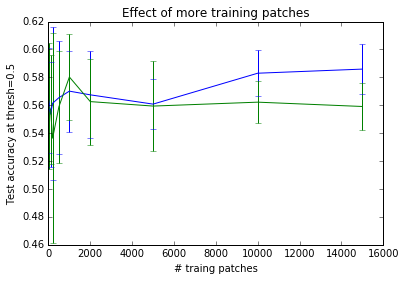

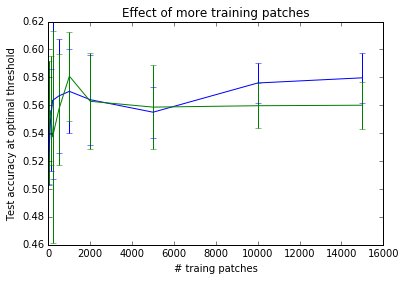

In [51]:
for test_condition in test_accs05_all_ntrain.values()[1].keys():
    ntrains, accs, errs = zip(*sorted([(ntrain, np.mean(x[test_condition]), np.std(x[test_condition]))
          for ntrain, x in test_accs05_all_ntrain.iteritems() if len(x) > 0]))
    plt.errorbar(ntrains, accs, yerr=errs, label=test_condition);
plt.title('Effect of more training patches');
plt.xlabel('# traing patches');
plt.ylabel('Test accuracy at thresh=0.5');
# plt.legend(loc='lower right');
# plt.ylim([0.5, 0.9]);
plt.show()

for test_condition in test_accs_all_ntrain.values()[1].keys():
    ntrains, accs, errs = zip(*sorted([(ntrain, np.mean(x[test_condition]), np.std(x[test_condition]))
          for ntrain, x in test_accs_all_ntrain.iteritems() if len(x) > 0]))
    plt.errorbar(ntrains, accs, yerr=errs, label=test_condition);
plt.title('Effect of more training patches');
plt.xlabel('# traing patches');
plt.ylabel('Test accuracy at optimal threshold');
# plt.legend(loc='lower right');
# plt.ylim([0.5, 0.9]);
plt.show()

In [60]:
# for test_condition in test_f1s05_all_ntrain.values()[1].keys():
#     ntrains, accs, errs = zip(*sorted([(ntrain, np.mean(x[test_condition]), np.std(x[test_condition]))
#           for ntrain, x in test_f1s05_all_ntrain.iteritems() if len(x) > 0]))
# #     plt.plot(ntrains, accs, label=test_condition);
#     plt.errorbar(ntrains, accs, yerr=errs, label=test_condition)
# plt.title('Effect of more training patches');
# plt.xlabel('# traing patches');
# plt.ylabel('f1 score at threshold = 0.5');
# plt.legend(loc='lower right');
# # plt.ylim([0.5, 1.]);
# plt.show();

# for test_condition in test_f1s_all_ntrain.values()[1].keys():
#     ntrains, accs, errs = zip(*sorted([(ntrain, np.mean(x[test_condition]), np.std(x[test_condition]))
#           for ntrain, x in test_f1s_all_ntrain.iteritems() if len(x) > 0]))
#     plt.errorbar(ntrains, accs, yerr=errs, label=test_condition);
# plt.title('Effect of more training patches');
# plt.xlabel('# traing patches');
# plt.ylabel('f1 score at optimal threshold');
# plt.legend(loc='upper right');
# plt.ylim([0.5, 1.]);
# plt.show();

In [31]:
import uuid

In [69]:
result = {
    'n_train_sections': n_train_sections,
    'n_test_sections': n_test_sections,
    'train_stack': train_stack,
    'test_stack': test_stack,
    'test_scheme': test_scheme,
    'train_scheme': train_scheme,
    'test_f1s_all_ntrain': test_f1s_all_ntrain,
    'test_accs_all_ntrain': test_accs_all_ntrain,
    'test_accs05_all_ntrain': test_accs05_all_ntrain,
    'test_f1s05_all_ntrain': test_f1s05_all_ntrain
}

save_pickle(result, ROOT_DIR + '/assessment_results/assessment_result_%s.pkl' % str(uuid.uuid1()).split('-')[0])

In [70]:
def plot_result(test_metrics_all_ntrain, ylabel):

    for test_condition in test_metrics_all_ntrain.values()[1].keys():
        ntrains, accs, errs = zip(*sorted([(ntrain, np.mean(x[test_condition]), np.std(x[test_condition]))
              for ntrain, x in test_metrics_all_ntrain.iteritems() if len(x) > 0]))
        plt.errorbar(ntrains, accs, yerr=errs, label=test_condition[1]);
#     plt.title('Effect of more training patches');
    plt.xlabel('# traing patches');
    plt.ylabel(ylabel);
    plt.legend(loc='upper right');
    plt.ylim([0.5, 1.]);
    plt.show()

train: MD589, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)
test: MD661, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)


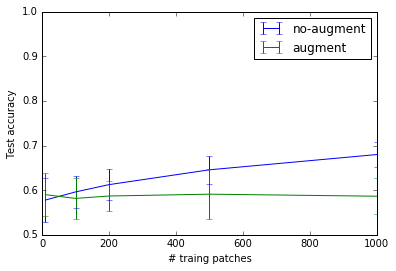

train: MD589, 89 sections, normalize_mu_region_sigma_wholeImage_(-1,5)
test: MD661, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)


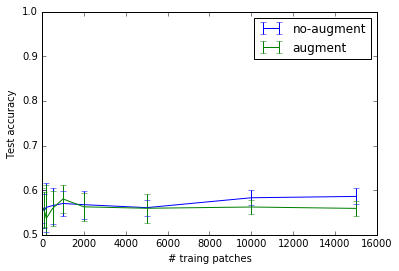

train: MD589, 10 sections, none
test: MD661, 10 sections, median_curve


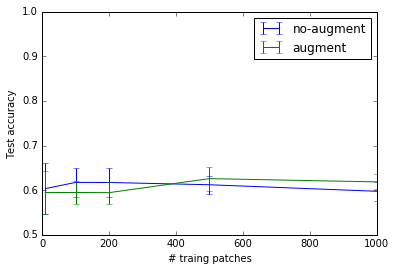

train: MD589, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)
test: MD661, 10 sections, median_curve


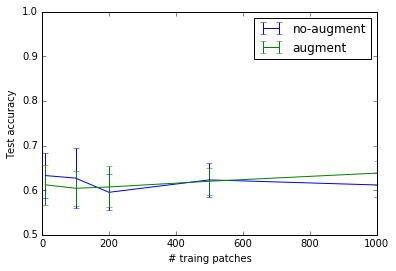

train: MD589, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)
test: MD661, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)


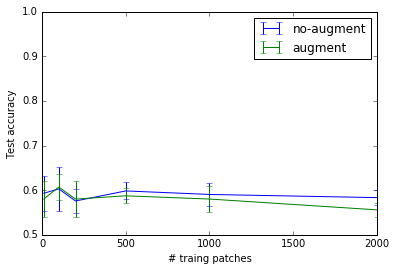

train: MD589, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)
test: MD661, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)


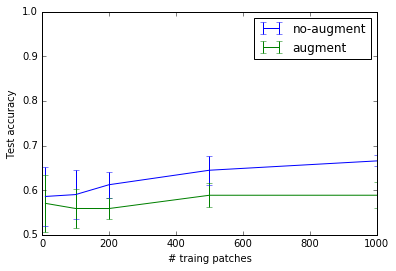

train: MD661, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)
test: ChatCryoJane201710, 10 sections, normalize_mu_region_sigma_wholeImage_(-1,5)


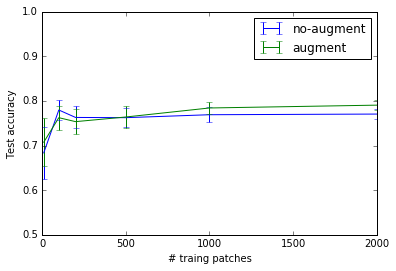

In [71]:
for fn in os.listdir(os.path.join(ROOT_DIR + '/assessment_results')):
    fp = os.path.join(ROOT_DIR + '/assessment_results', fn)
    res = load_pickle(fp)
    print 'train: %s, %d sections, %s' % (res['train_stack'], res['n_train_sections'], res['train_scheme'])
    print 'test: %s, %d sections, %s' % (res['test_stack'], res['n_test_sections'], res['test_scheme'])
    plot_result(res['test_accs05_all_ntrain'], ylabel='Test accuracy')

In [ ]:
# plt.boxplot(training_accuracies.values(), labels=training_accuracies.keys());
# plt.boxplot(test_accuracies.values(), labels=training_accuracies.keys());
plt.boxplot(training_f1s.values());
plt.boxplot(test_f1s.values());
plt.ylabel('F1 score');
# plt.ylim([0.75, 1.]);

print 'Mean test F1:'
print {k: np.mean(v) for k, v in test_f1s.iteritems()}

In [ ]:
# plt.boxplot(training_accuracies.values(), labels=training_accuracies.keys());
# plt.boxplot(test_accuracies.values(), labels=training_accuracies.keys());
plt.boxplot(training_accuracies.values());
plt.boxplot(test_accuracies.values());
plt.ylabel('Accuracy');
# plt.ylim([0.75, 1.]);

print 'Mean test acc:'
print {k: np.mean(v) for k, v in test_accuracies.iteritems()}

# Inspect scoremap for local regions around a certain landmark.

In [200]:
from data_manager import *

In [201]:
DataManager.clear_image_cache()

In [72]:
# local_region_bbox_all_structures_all_sections = get_local_regions(stack='ChatCryoJane201710')
local_region_bbox_all_structures_all_sections = get_local_regions(stack=test_stack, margin_um=5000)

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD661" "/home/yuncong/CSHL_labelings_v3/MD661" --exclude "*" --include "*contours*"
latest timestamp:  12122017183504


In [60]:
# train_scheme = 'none'
train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'median_curve'
# train_scheme = 'stretch_min_max'
# test_scheme = 'stretch_min_max'

n_train = 1000

# If train and test data are from different sets
#     n_train_pos = 5000
n_train_pos = n_train
# if len(positive_addresses_traindata) < n_train_pos:
#     continue
training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)

###############

# If train and test data are from different sets
#     n_train_neg = 5000
n_train_neg = n_train
training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)

print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
# print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

################

# If train and test data are from different sets
addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]

#################

augment_training = False

feature_classifier_alg = 'lr'
#             feature_classifier_alg = 'xgb2'
#             feature_classifier_alg = 'lin_svc'
#             feature_classifier_alg = 'lin_svc_calib'
sample_weights = None   

if augment_training:
    train_transforms = range(8)
else:
    train_transforms = range(1)

test_transforms = range(1)

features_train_pos = {(train_scheme, 'transform%d'%tf_variant): 
                      [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                       for addr in addresses_train_pos]
                          for tf_variant in train_transforms}
features_train_neg = {(train_scheme, 'transform%d'%tf_variant): 
                      [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                       for addr in addresses_train_neg]
                          for tf_variant in train_transforms}

if augment_training:

    train_data_list = []
    train_label_list = []
    for tf in range(8):
        train_data = np.r_[features_train_pos[(train_scheme,'transform%d'%tf)], 
                           features_train_neg[(train_scheme,'transform%d'%tf)]]
        train_data_list.append(train_data)

        train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform%d'%tf)]), )), 
                             -np.ones((len(features_train_neg[(train_scheme,'transform%d'%tf)]), ))]
        train_label_list.append(train_labels)

    train_data = np.concatenate(train_data_list)
    train_labels = np.concatenate(train_label_list)        
else:

    train_data = np.r_[features_train_pos[(train_scheme,'transform0')], 
                       features_train_neg[(train_scheme,'transform0')]]
    train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform0')]), )), 
                         -np.ones((len(features_train_neg[(train_scheme,'transform0')]), ))]


clf = train_binary_classifier(train_data, train_labels,
                       alg=feature_classifier_alg, 
                       sample_weights=sample_weights)

Training: 1000 positive, 1000 negative


Fitting classifier: 0.55 seconds


In [134]:
# base_image_cache = {sec: DataManager.load_image_v2(stack='ChatCryoJane201710', prep_id=2, version='NtbJpeg', section=sec)
#                    for sec in range(90, 130, 5)}

# base_image_cache = {sec: DataManager.load_image_v2(stack='MD661', prep_id=2, version='grayJpeg', section=sec)
# #                    for sec in range(90, 130, 5)
#                     for sec in local_region_bbox_all_structures_all_sections['7N_L'].keys()[::10]
#                    }

In [ ]:
metadata_cache['sections_to_filenames']['ChatCryoJane201710'][113]

In [91]:
metadata_cache['sections_to_filenames']['MD661'][157]

'MD662&661-F54-2017.06.22-17.00.44_MD661_1_0160'

In [35]:
DataManager.disable_image_cache()

locate patches: 0.08 seconds
Not using image_cache.
Load image: 14.90 seconds.
Extract patches: 71.23 seconds


(43589, 1, 224, 224)


Not using image_cache.


(1968, 2717, 3) (1968, 2717)


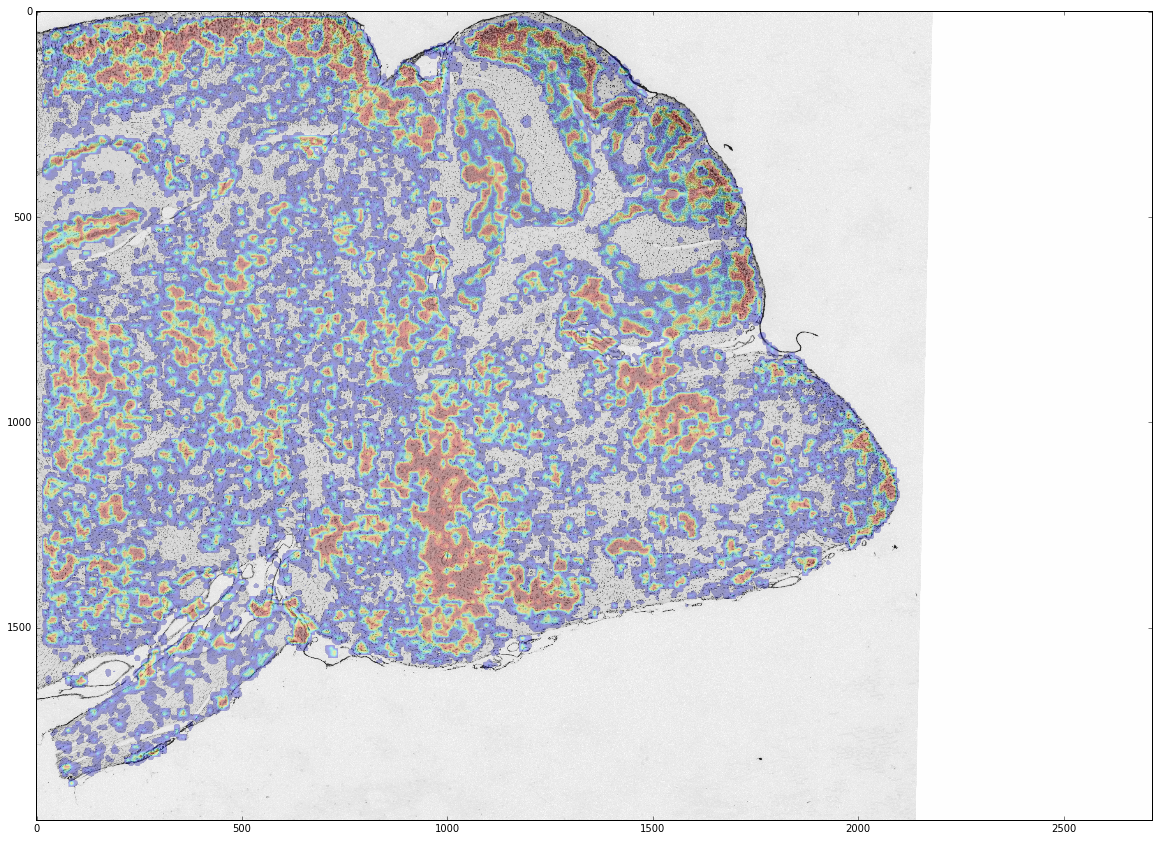

In [93]:
# for sec in local_region_bbox_all_structures_all_sections['7N_L'].keys()[::10]:
for sec in [157]:
    viz = draw_scoremap(clf=clf, structure='7N_L', 
                        scheme=test_scheme,
                        bbox=local_region_bbox_all_structures_all_sections['7N_L'][sec], 
                        stack=test_stack, sec=sec,
#                        bg_img=base_image_cache[sec],
                       feature='cnn', model=model, mean_img=mean_img, batch_size=batch_size)
    plt.figure(figsize=(20,20));
    plt.imshow(viz);
    plt.show();

# ROC

In [39]:
negative_composition_rules = ['surround500']

In [40]:
fixed_n_pos = 500
fixed_n_neg = 500

In [239]:
acc_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# fn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# tn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
precision_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
recall_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
f1score_normalized_all_clfs_all_structures_all_negcomprule =  defaultdict(lambda: defaultdict(dict))

classifier_ids = [0]

for classifier_id in classifier_ids:
    
    clf_allClasses = trained_classifiers

    ####################################################
    # Compute accuracy against each structure surround #
    ####################################################
    
    for neg_composition_rule in negative_composition_rules:
            
        ncols = 5
        nrows = int(np.ceil(len(structures_found)/float(ncols)))

    #     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
    #     axes = axes.flatten()

        for i, structure in enumerate(structures_found):

#             features_pos = test_features[structure]
            features_pos = features_pos_unused
    
            if fixed_n_pos is not None:
                features_pos = features_pos[np.random.choice(range( len(features_pos)), replace=False, size=(min(fixed_n_pos, len(features_pos)),))]

            n_pos = len(features_pos)
            print structure, n_pos, 'positive'

            if neg_composition_rule.startswith('surround'):
                if neg_composition_rule == 'surround200':
                    margin_um = 200
                elif neg_composition_rule == 'surround500':
                    margin_um = 500
                elif neg_composition_rule == 'surround1000':
                    margin_um = 1000
                else:
                    margin_um = None
                neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
                [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in structures_found]
            elif neg_composition_rule == 'negative':
                neg_classes = [structure + '_negative']
            else:
                raise
            
            neg_classes = list(set(neg_classes) & set(labels_found))

#             features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
            features_neg = features_neg_unused
    
            if fixed_n_neg is not None:
                features_neg = features_neg[np.random.choice(range( len(features_neg)), replace=False, size=(min(fixed_n_neg, len(features_neg)),))]        

            n_neg = len(features_neg)
            print structure, n_neg, 'negative'

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            if structure not in clf_allClasses:
                sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
                continue

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            
            
            ######### SOFT ########
#             cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
#                                              normalize=False)
#             tp = cm[0,0]
#             fn = cm[0,1]
#             fp = cm[1,0]
#             tn = cm[1,1]

#             acc = (tp + tn) / (n_pos + n_neg)
#             acc_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = acc

            ######## PRECISION-RECALL ########
            precision_allthresh = {}
            recall_allthresh = {}
            f1score_allthresh = {}
            tp_normalized_allthresh = {}
            fp_normalized_allthresh = {}
            for th in np.arange(0., 1., 0.01):
            
                cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=False,
                                             normalize=False, binary=True, decision_thresh=th)

                tp = cm[0,0]
                fn = cm[0,1]
                fp = cm[1,0]
                tn = cm[1,1]
                
                tp_normalized = tp / n_pos
#                 fn_normalized = fn / n_pos
                fp_normalized = fp / n_neg
#                 tn_normalized = tn / n_neg

                precision = float(tp) / (tp + fp)
                recall = float(tp) / (tp + fn)
                f1score = 2*recall*precision/(recall+precision)
                
                tp_normalized_allthresh[float(th)] = tp_normalized
                fp_normalized_allthresh[float(th)] = fp_normalized
                precision_allthresh[float(th)] = precision
                recall_allthresh[float(th)] = recall
                f1score_allthresh[float(th)] = f1score

            tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tp_normalized_allthresh
#             fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized_allthresh
            fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fp_normalized_allthresh
#             tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized_allthresh
            precision_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = precision_allthresh
            recall_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = recall_allthresh
            f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = f1score_allthresh
    #     plt.tight_layout()

        ############################

#         xticks = range(1, 1 + len(structures_sorted_by_size))

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [acc_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size]);
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylim([0.6, 1]);
#         plt.ylabel('Accuracy');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.show();

#         print 'test accuracy:', np.mean(acc_all_clfs_all_structures[classifier_id].values())

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [tp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tp', markerfmt='bo');
#         plt.stem(xticks, [fn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fn', markerfmt='ro');
#         plt.stem(xticks, [fp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fp', markerfmt='ko');
#         plt.stem(xticks, [tn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tn', markerfmt='go');
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylabel('Percentage');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.legend();
#         plt.show();

tp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# fn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# tn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
precision_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
recall_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
f1score_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None

SNR 500 positive
SNR 500 negative


In [240]:
structures_sorted_by_size = ['SNR']

In [241]:
fopt_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
optthresh_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))

for classifier_id in classifier_ids:

    for neg_composition_rule in negative_composition_rules:

        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f_allthresh[th] for th in np.arange(0, 1, 0.01)])]
            optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = optimal_th
            fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = f_allthresh[optimal_th]

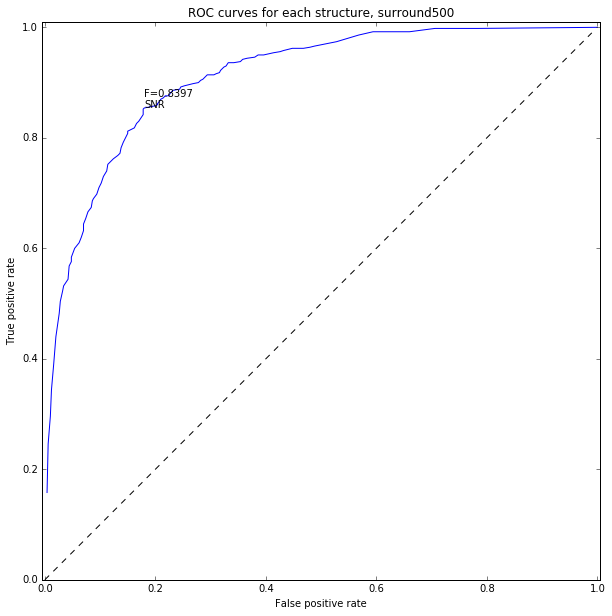

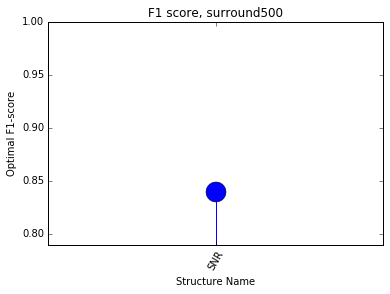

In [242]:
for classifier_id in classifier_ids:
    for neg_composition_rule in negative_composition_rules:

    #     plt.figure(figsize=(15, 10));
        plt.figure(figsize=(10, 10));
        plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='k', linestyle='--');

        fopt = {}
        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            plt.plot([fp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)],
                 [tp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)]);

            optimal_th = optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            fopt = f_allthresh[optimal_th]

    #         plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
    #             marker='o', facecolors='none', edgecolors='k')
            plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th]+.02, 'F=%.4f' % (fopt))
            plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], s, fontsize=10)

    #     plt.legend();
        plt.ylabel('True positive rate');
        plt.xlabel('False positive rate');
    #     plt.xticks(np.arange(0,1,.1));
        plt.axis('equal');
        plt.ylim([0,1.01]);
        plt.xlim([0,1]);
        plt.title('ROC curves for each structure, %s' % (neg_composition_rule));
        plt.show();

    #     plt.figure();
    #     plt.hist(fopt.values(), bins=np.arange(0.7, 1.0, 0.01));
    #     plt.ylabel("Number of structures");
    #     plt.xlabel("Optimal f1 score");
    #     plt.show();

        plt.figure();
        xticks = range(1, 1 + len(structures_sorted_by_size))
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                                                       [fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size],
         markerfmt='o', markevery=[4,8]);
        plt.setp(markerLines, markersize=20, alpha=1.)
        plt.xticks(xticks, structures_sorted_by_size, rotation='60');
        plt.ylabel('Optimal F1-score');
        plt.xlabel('Structure Name');
        plt.ylim(np.min([fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size])-.05, 1);
        plt.title('F1 score, %s' % (neg_composition_rule));
        plt.legend();
        plt.show();